In [48]:
#Feature selection

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import roc_auc_score, recall_score, precision_score, balanced_accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
warnings.filterwarnings('ignore')

In [3]:
gene_expr_df = pd.read_csv("datasets/merged-combat15.csv")
outcome_df = pd.read_csv("datasets/combat15outcomes_latest.csv")
pos_outcome_df = outcome_df[["patient_ID", "posOutcome"]].dropna(axis=0, subset=["posOutcome"])
pos_outcome_df.posOutcome = pos_outcome_df.posOutcome.astype(int)
ge_pos_outcome_df = pd.merge(pos_outcome_df, gene_expr_df, on="patient_ID")
X, y = ge_pos_outcome_df[ge_pos_outcome_df.columns.difference(["posOutcome"])], ge_pos_outcome_df["posOutcome"]

print("X shape " + str(X.shape))

X shape (2237, 8833)


In [78]:
rand_seed = 42
params = {'n_estimators': [300, 400, 500, 600, 700],
              'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'max_depth': [3, 4, 5, 6],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'min_child_weight': [1, 2, 3, 4, 5]}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_seed, stratify=y)

train_df = pd.concat([y_train, X_train], axis=1)
test_df = pd.concat([y_test, X_test], axis=1)

train_df.to_csv("datasets/train.csv", index=False)
test_df.to_csv("datasets/test.csv", index=False)
X_train.drop("patient_ID", axis=1, inplace=True)
X_test.drop("patient_ID", axis=1, inplace=True)

In [8]:
xgb_params_1 = {'subsample': 0.6,
 'n_estimators': 700,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.03,
 'gamma': 0.5,
 'colsample_bytree': 0.8}


clf = XGBClassifier(**xgb_params_1, n_jobs=14)

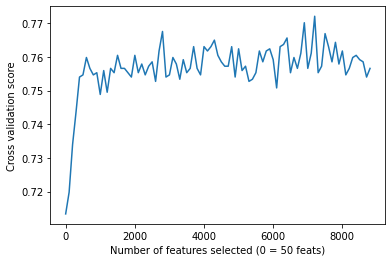

In [94]:
import matplotlib.ticker as ticker

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_seed)
feat_selector = RFECV(clf, step=100, cv=cv, min_features_to_select=50)
feat_selector.fit(X_train, y_train)
feat_selector.ranking_
min_features = 50
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Number of features selected (0 = 50 feats)")
ax1.set_ylabel("Cross validation score")
X = [x for x in range(0, len(feat_selector.grid_scores_))]
ax1.plot(X, feat_selector.grid_scores_)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
ax1.xaxis.set_major_formatter(ticks_x)
plt.show()

In [29]:
inds = np.argpartition(feat_selector.grid_scores_, 50)[-50:]
inds[np.argsort(feat_selector.grid_scores_[inds])]

array([38, 16, 82, 24, 46, 74, 52, 47, 79, 22, 32, 77, 45, 25, 86, 57, 60,
       34, 85, 66, 83,  6, 31, 84, 20, 15, 44, 71, 68, 56, 58, 80, 41, 27,
       59, 50, 48, 62, 76, 42, 40, 37, 63, 78, 43, 64, 75, 28, 69, 72])

In [98]:
feat_selector.grid_scores_[72]

0.772107735671782

In [100]:
ft_rank_df = pd.DataFrame(feat_selector.ranking_, index=X_train.columns,
                         columns=["Rank"]).sort_values(by="Rank",
                                                       ascending=False)

In [61]:
X_subset = X_train.loc  [:, feat_selector.support_]
X_subset.to_csv("datasets/train_subset.csv")

In [101]:
ft_rank_df.head(n=50)

,Rank
A4GALT,17
NLK,17
NKX6-1,17
NKX2-8,17
NKRF,17
NKIRAS2,17
NKG7,17
NIT2,17
NIP7,17
NINJ1,17


In [108]:
feat_selector.support_

array([False, False, False, ..., False, False, False])

In [9]:
rfe = RFE(clf, n_features_to_select=500, step=49)
rfe.fit(X_train, y_train)
rfe.ranking_

[18:20:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:21:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:22:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([172, 171, 162, ..., 144, 164, 167])

In [81]:
ft_rank = pd.DataFrame(rfe.ranking_, index=X_train.columns,
                         columns=["Rank"]).sort_values(by="Rank")

ft_rank_500_df = ft_rank[ft_rank["Rank"] == 1]
ft_rank_500_df

,Rank
LITAF,1
TPBG,1
CCRL2,1
ZNF268,1
CCT6B,1
...,...
ADRB3,1
ADAMTSL2,1
ANXA7,1
ABI1,1


In [36]:
with open("datasets/xgb500_genes.txt", "w") as fp:
    for i in range(ft_rank_500_df.shape[0]):
        fp.write(ft_rank_500_df.iloc[i].name + "\n")

In [41]:
from sklearn.metrics import make_scorer
def recall_0(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

def precision_0(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=0)

scoring = {"balanced_accuracy": make_scorer(balanced_accuracy_score),
           "recall_0": make_scorer(recall_0), "precision_0": make_scorer(precision_0),
           "recall_1": make_scorer(recall_score), "precision_1": make_scorer(precision_score), "auc": "roc_auc" }

In [71]:
feats_500 = []

for i in range(ft_rank_500_df.shape[0]):
    feats_500.append(ft_rank_500_df.iloc[i].name)

X_500_train = X_train[feats_500]
X_500_train.head()

,LITAF,TPBG,CCRL2,ZNF268,CCT6B,CD163,CD320,KIF17,KIF1A,CD44,...,WDR62,ADORA3,AP1B1,HGD,WHSC1L1,ADRB3,ADAMTSL2,ANXA7,ABI1,AHR
1084,7.108456,7.463690,3.841445,4.848988,2.944146,5.316088,6.127067,3.629676,6.434729,6.424752,...,3.472400,3.884389,6.602958,2.997926,6.027037,3.148324,3.284457,8.879693,7.774435,8.399100
84,8.271182,9.319451,4.015521,3.670656,2.949599,7.182012,5.874283,3.501298,2.533096,7.274651,...,3.302293,4.162791,6.752108,4.526801,2.932985,3.351544,3.711498,8.241469,6.846877,7.129267
1164,7.894494,8.052706,5.259943,5.552700,3.145896,7.906607,4.067954,3.641523,3.108423,8.087042,...,2.748002,5.146482,7.613484,2.615693,3.983403,3.288953,3.839644,8.194948,8.402202,8.111880
1833,8.651722,9.158700,3.778845,5.629598,3.096840,7.099068,5.485791,3.600242,3.262309,6.773035,...,3.646378,3.597345,6.584821,5.801371,3.740626,3.062545,3.242531,8.907759,7.684565,6.964725
1366,8.440454,6.642578,5.889477,4.645318,3.188979,10.478267,5.705050,3.607868,3.293778,6.724959,...,4.108428,7.332183,8.042622,3.921174,3.752512,3.593116,3.241774,8.678762,7.637010,6.882944


In [72]:
st_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=rand_seed)
clf_500 = XGBClassifier(**xgb_params_1)
cv_results = cross_validate(clf_500, X_500_train, y_train, cv=st_cv,
                            n_jobs=-1, verbose=2, return_train_score=True,
                            return_estimator=True, scoring=scoring)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  3.4min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.4min finished


In [74]:
score_cols = ["test_balanced_accuracy", "train_balanced_accuracy", "test_recall_0",
              "train_recall_0", "test_precision_0", "train_precision_0",
              "test_recall_1","train_recall_1", "test_precision_1",
              "train_precision_1" ,"test_auc", "train_auc"]

def get_score_df(cross_val_res, folds=5, cols=score_cols):
    scores_arr = np.empty([folds, 12])
    for j, s in enumerate(score_cols):
        scores_arr[:,j] = cross_val_res[s]

    return pd.DataFrame(data=scores_arr, columns=score_cols)

scores_500_df = get_score_df(cv_results, folds=10)
scores_500_df.filter(like="test").mean()

test_balanced_accuracy    0.825130
test_recall_0             0.832692
test_precision_0          0.837339
test_recall_1             0.817568
test_precision_1          0.816463
test_auc                  0.915819
dtype: float64

In [75]:
clf_500 = XGBClassifier(**xgb_params_1, n_jobs=16)
clf_500.fit(X_500_train, y_train)

[17:21:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [76]:
def calc_scores(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    recall_0, recall_1 = recall_score(y_test, y_pred, pos_label=0), recall_score(y_test, y_pred, pos_label=1)
    precision_0, precision_1 =  precision_score(y_test, y_pred, pos_label=0), precision_score(y_test, y_pred, pos_label=1)
    acc = balanced_accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    return np.array([[acc, recall_0, precision_0, recall_1, precision_1, auc_score]])

In [77]:
X_test_500 = X_test[feats_500]
scores_test_500 = calc_scores(clf_500, X_test_500, y_test)
scores_test_500_df = pd.DataFrame(data=scores_test_500, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
scores_test_500_df.mean()

balanced_accuracy    0.761060
recall_0             0.776836
precision_0          0.772472
recall_1             0.745283
precision_1          0.750000
auc                  0.851189
dtype: float64

,A4GALT,AAAS,AACS,AADAC,AAK1,AAMP,AANAT,AARS,AARSD1,AASDHPPT,...,ZNHIT2,ZP2,ZPBP,ZSCAN2,ZW10,ZWINT,ZXDC,ZYX,ZZEF1,ZZZ3
1084,3.490594,4.705177,7.388903,3.146066,5.324219,7.010299,3.204220,7.623260,4.908548,7.920498,...,3.616936,3.177763,3.120909,3.626377,5.573573,7.840314,5.720305,7.491440,7.049239,6.979166
84,3.493298,6.025729,6.501462,3.015961,4.639765,7.399345,3.801613,8.326222,5.075999,6.635090,...,4.002873,3.182145,3.414617,3.933382,3.717363,9.053191,6.370379,7.888914,5.422555,5.951768
1164,3.426142,5.449551,5.632613,3.685224,5.643874,6.737401,3.596668,7.431818,5.591313,6.596328,...,2.695141,3.324802,3.251439,2.909459,4.385828,6.415808,5.480143,7.644960,6.797248,6.808280
1833,3.426381,5.595401,6.882855,3.240755,6.075660,6.943799,3.202970,7.477471,4.904070,6.518033,...,3.384700,3.144302,3.158701,3.521218,3.968905,6.774039,6.299851,7.620011,5.797529,5.871506
1366,3.479792,5.565861,4.662279,3.176784,6.033194,7.274996,3.204731,7.105333,6.663767,6.667291,...,3.414956,3.139913,3.185299,3.572568,3.874406,6.490379,6.589065,6.327172,6.770991,6.890959
